In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import itertools

import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from datasets import Dataset, DatasetDict, ClassLabel, Value, Features
from transformers import AutoTokenizer
from transformers import TFAutoModel
from transformers import TFAutoModelForSequenceClassification

from sklearn.preprocessing import StandardScaler

from torch.nn.functional import cross_entropy
import umap

In [2]:
tdf = pd.read_csv('Data\\twitter_training.csv')
vdf = pd.read_csv('Data\\twitter_validation.csv')

In [3]:
y = 1
for index, row in tdf.iterrows():
    if y >= 2:
        tdf = tdf.drop(index)
    if y == 6:
        y = 1
    else:
        y= y + 1

In [4]:
tdf = tdf.replace("Irrelevant", "Neutral")

In [5]:
def Cleaning(x):
    lemmatizer = WordNetLemmatizer()
    x = str(x)
    na = nltk.regexp_tokenize(x.lower(), r'(\b[\w]{2,}\b)')
    naa = []
    for z in na:
        naa.append(lemmatizer.lemmatize(z))
    nnaa = " ".join(naa)
    return nnaa

def RSW(x):
    x = str(x)
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.regexp_tokenize(x.lower(), r'(\b[\w]{2,}\b)')
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    nt = " ".join(filtered_sentence)
    return nt

#Creating Lem With Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    tdf.loc[g, "clean_Comment"] = Cleaning(oa)

#Creating No Lem With out Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    tdf.loc[g, "No_Stop_Words_Comment"] = RSW(oa)
#Creating Lem With Out Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    ns = Cleaning(oa)
    nns = RSW(ns)
    tdf.loc[g, "No_Stop_Words_Lemmatized_Comment"] = nns

In [6]:
tdf['Comment'] = tdf['Comment'].astype(str)
tdf['clean_Comment'] = tdf['clean_Comment'].astype(str)
tdf['No_Stop_Words_Comment'] = tdf['No_Stop_Words_Comment'].astype(str)
tdf['No_Stop_Words_Lemmatized_Comment'] = tdf['No_Stop_Words_Lemmatized_Comment'].astype(str)

In [7]:
tdf.drop('Topic', axis=1, inplace=True)

In [9]:
tdf['ID'] = tdf['ID'].astype(str)
tdf['No_Stop_Words_Lemmatized_Comment'] = tdf['No_Stop_Words_Lemmatized_Comment'].astype(str)

In [10]:
X_train, X_test = train_test_split(tdf, test_size=0.20, random_state=17)
data_dir = Path('data2')

X_train['split'] = 'train'
X_test['split'] = 'test'
X = pd.concat([X_train, X_test])
X['path'] = X.apply(lambda x:data_dir.joinpath(x.split, x.Sentiment, x.ID+'.txt'), axis=1)

def save_file(text:str, path: Path):

    if not path.parent.exists():
        path.parent.mkdir(exist_ok=True, parents=True)
    path.write_text(text, encoding='utf-8')

X.apply(lambda x:save_file(x.No_Stop_Words_Lemmatized_Comment, x.path), axis=1)

2064     None
24498    None
45684    None
69330    None
67356    None
         ... 
69204    None
73782    None
59454    None
35430    None
44274    None
Length: 12447, dtype: object

In [2]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
	'data2/train',
    class_names = ['Positive', 'Negative', "Neutral"],
	batch_size=batch_size,
	validation_split=0.2,
	subset='training',
	seed=seed)

Found 9957 files belonging to 3 classes.
Using 7966 files for training.


In [3]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'data2/train',
    class_names = ['Positive', 'Negative', "Neutral"],
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
    )

Found 9957 files belonging to 3 classes.
Using 1991 files for validation.


In [4]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'data2/test',
    class_names = ['Positive', 'Negative', "Neutral"],
    batch_size=batch_size)

Found 2490 files belonging to 3 classes.


In [5]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [6]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [7]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [8]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
embedding_dim = 16

In [66]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(30),
  layers.Dropout(0.2),
  layers.Dense(30),
  layers.Dropout(0.2),
  layers.Dense(30),
  layers.Dropout(0.2),
  layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
model_ckpt = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10,  restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[model_ckpt])

Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3939 - loss: 1.0919 - val_accuracy: 0.4309 - val_loss: 1.0785
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4063 - loss: 1.0891 - val_accuracy: 0.4309 - val_loss: 1.0771
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4065 - loss: 1.0887 - val_accuracy: 0.4309 - val_loss: 1.0764
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4050 - loss: 1.0884 - val_accuracy: 0.4309 - val_loss: 1.0750
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4048 - loss: 1.0856 - val_accuracy: 0.4309 - val_loss: 1.0724
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4108 - loss: 1.0828 - val_accuracy: 0.4309 - val_loss: 1.0705
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4314 - loss: 1.0648 - val_accuracy: 0.4455 - val_loss: 1.0299
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4711 - loss: 1.0251 - val_accuracy: 0.

In [69]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.6163 - loss: 0.8991
Loss:  0.8770826458930969
Accuracy:  0.6156626343727112


In [70]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

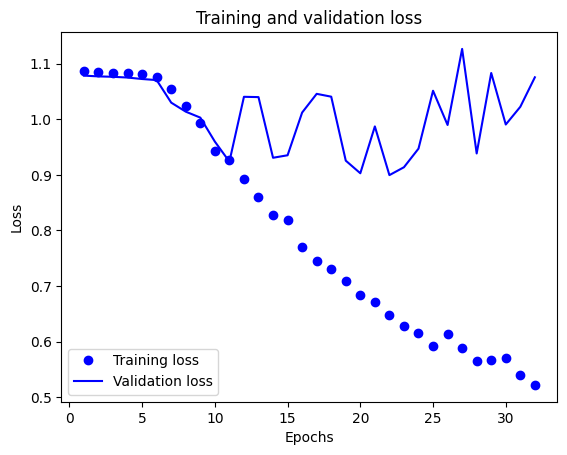

In [71]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [72]:
y_pred = np.argmax(model.predict(test_ds), axis=1).astype(int) 
y_true = np.concatenate([y for x, y in test_ds], axis=0)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


In [73]:
y_pred

array([0, 2, 2, ..., 2, 2, 2])

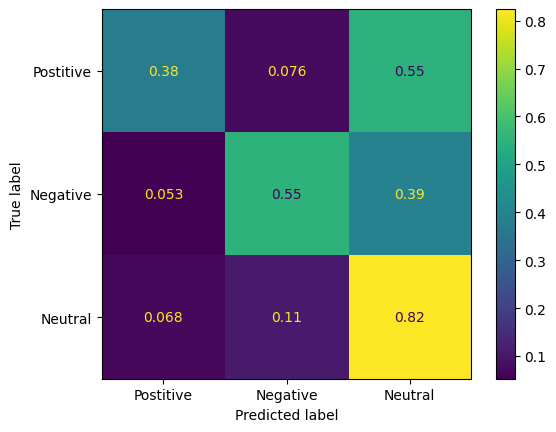

In [74]:
metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Postitive", "Negative", "Neutral"],normalize= "true")
plt.show()

In [75]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=['accuracy']
)

metricsx = export_model.evaluate(raw_test_ds, return_dict=True)
print(metricsx)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6144 - loss: 0.9347
{'accuracy': 0.6156626343727112, 'loss': 0.9310095906257629}


In [76]:
def get_answer(textlist):
    thing = export_model.predict(textlist)
    newlist = []
    for x in thing:
        if x[0] > x[1] and x[0] > x[2]:
            newlist.append("Positive")
        elif x[1] > x[0] and x[1] > x[2]:
            newlist.append("Negative")
        elif x[2] > x[0] and x[2] > x[1]:
            newlist.append("Neutral")
    return newlist


In [77]:
examples = tf.constant([
  "This is the best model ever.",
  "This is the worst model ever.",
  "I have seen better models but this one is okay."
  ])

get_answer(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


['Neutral', 'Negative', 'Neutral']